<a href="https://colab.research.google.com/github/ZeeeeCS/Sales-Forcasting-For-retail-store/blob/main/ThirdSalesForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [47]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
# Upload Kaggle API Key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amscientist","key":"033eda4bde2d7486d7d07bf9f10f1cc5"}'}

In [7]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download anirudhchauhan/retail-store-inventory-forecasting-dataset


Dataset URL: https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset
License(s): CC0-1.0


In [8]:
# Unzip Dataset
!unzip retail-store-inventory-forecasting-dataset.zip

Archive:  retail-store-inventory-forecasting-dataset.zip
  inflating: retail_store_inventory.csv  


In [9]:
# Load Data
data_sales=pd.read_csv('/content/retail_store_inventory.csv')

In [ ]:
data_sales.head(10)

In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
data_sales.shape

(73100, 15)

In [81]:
# Convert Categorical Columns
data_sales[['Region','Category','Seasonality','Weather Condition']]=data_sales[['Region','Category','Seasonality','Weather Condition']].astype('category')

In [ ]:
just_test=data_sales.copy()

In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Date                73100 non-null  object  
 1   Store ID            73100 non-null  object  
 2   Product ID          73100 non-null  object  
 3   Category            73100 non-null  category
 4   Region              73100 non-null  category
 5   Inventory Level     73100 non-null  int64   
 6   Units Sold          73100 non-null  int64   
 7   Units Ordered       73100 non-null  int64   
 8   Demand Forecast     73100 non-null  float64 
 9   Price               73100 non-null  float64 
 10  Discount            73100 non-null  int64   
 11  Weather Condition   73100 non-null  category
 12  Holiday/Promotion   73100 non-null  int64   
 13  Competitor Pricing  73100 non-null  float64 
 14  Seasonality         73100 non-null  category
dtypes: category(4), float64(3), int64(5)

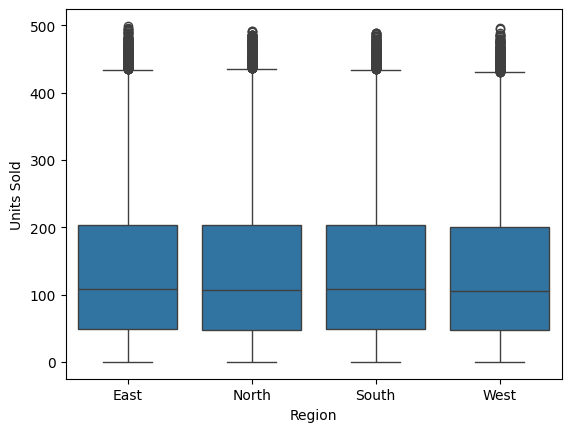

In [ ]:
# Boxplots the distribution of 'Units Sold' by Region
sns.boxplot(data=data_sales,x='Region',y='Units Sold')
plt.show()

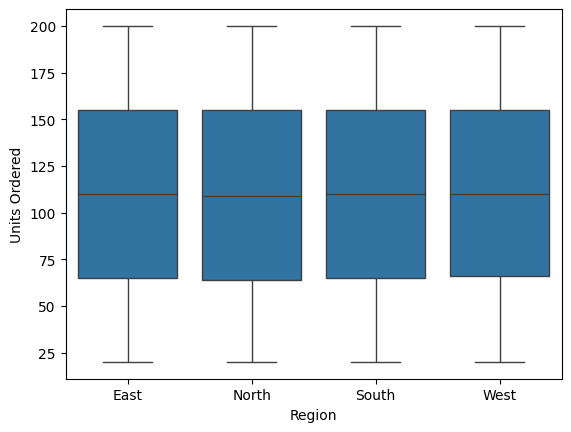

In [ ]:
# Boxplots the distribution of 'Units Ordered' by Region
sns.boxplot(data=data_sales,x='Region',y='Units Ordered')
plt.show()

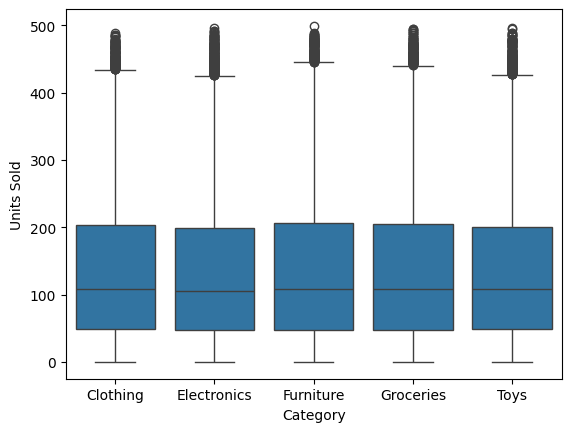

In [ ]:
sns.boxplot(data=data_sales,x='Category',y='Units Sold')
plt.show()

In [ ]:
# Check for Missing Values
data_sales.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [ ]:
# Descriptive Statistics
data_sales.describe()

Inventory Level    Units Sold  Units Ordered  Demand Forecast  \
count     73100.000000  73100.000000   73100.000000     73100.000000   
mean        274.469877    136.464870     110.004473       141.494720   
std         129.949514    108.919406      52.277448       109.254076   
min          50.000000      0.000000      20.000000        -9.990000   
25%         162.000000     49.000000      65.000000        53.670000   
50%         273.000000    107.000000     110.000000       113.015000   
75%         387.000000    203.000000     155.000000       208.052500   
max         500.000000    499.000000     200.000000       518.550000   

              Price      Discount  Holiday/Promotion  Competitor Pricing  
count  73100.000000  73100.000000       73100.000000        73100.000000  
mean      55.135108     10.009508           0.497305           55.146077  
std       26.021945      7.083746           0.499996           26.191408  
min       10.000000      0.000000           0.000000            5.030000  
25%       32.650000      5.000000           0.000000           32.680000  
50%       55.050000     10.000000           0.000000           55.010000  
75%       77.860000     15.000000           1.000000           77.820000  
max      100.000000     20.000000           1.000000          104.940000

In [82]:
# Correlation Analysis
corrlation=data_sales.copy()
corrlation.drop(columns=['Date','Store ID','Product ID'],inplace=True)

for col in ['Region','Category','Seasonality','Weather Condition']:
    corrlation[col]=corrlation[col].astype('category').cat.codes

corrlation.corr()

Category    Region  Inventory Level  Units Sold  \
Category            1.000000  0.000841         0.001439    0.000512   
Region              0.000841  1.000000        -0.006837   -0.003109   
Inventory Level     0.001439 -0.006837         1.000000    0.589995   
Units Sold          0.000512 -0.003109         0.589995    1.000000   
Units Ordered      -0.001686  0.003172         0.001060   -0.000930   
Demand Forecast     0.000495 -0.002467         0.588561    0.996853   
Price               0.001375 -0.003576         0.009140    0.001082   
Discount           -0.001784 -0.002696         0.004889    0.002576   
Weather Condition  -0.000624  0.000209         0.001898    0.004688   
Holiday/Promotion  -0.000864 -0.001074         0.003411   -0.000374   
Competitor Pricing  0.000947 -0.003389         0.009365    0.001259   
Seasonality        -0.001474 -0.000785        -0.003425   -0.003324   

                    Units Ordered  Demand Forecast     Price  Discount  \
Category                -0.001686         0.000495  0.001375 -0.001784   
Region                   0.003172        -0.002467 -0.003576 -0.002696   
Inventory Level          0.001060         0.588561  0.009140  0.004889   
Units Sold              -0.000930         0.996853  0.001082  0.002576   
Units Ordered            1.000000        -0.001102  0.004212 -0.000938   
Demand Forecast         -0.001102         1.000000  0.000675  0.002338   
Price                    0.004212         0.000675  1.000000  0.001509   
Discount                -0.000938         0.002338  0.001509  1.000000   
Weather Condition       -0.001064         0.004768 -0.007715 -0.002302   
Holiday/Promotion        0.005446        -0.000526  0.002309 -0.000852   
Competitor Pricing       0.004596         0.000844  0.993900  0.001958   
Seasonality              0.003492        -0.003109  0.005095 -0.004622   

                    Weather Condition  Holiday/Promotion  Competitor Pricing  \
Category                    -0.000624          -0.000864            0.000947   
Region                       0.000209          -0.001074           -0.003389   
Inventory Level              0.001898           0.003411            0.009365   
Units Sold                   0.004688          -0.000374            0.001259   
Units Ordered               -0.001064           0.005446            0.004596   
Demand Forecast              0.004768          -0.000526            0.000844   
Price                       -0.007715           0.002309            0.993900   
Discount                    -0.002302          -0.000852            0.001958   
Weather Condition            1.000000          -0.002408           -0.007440   
Holiday/Promotion           -0.002408           1.000000            0.001890   
Competitor Pricing          -0.007440           0.001890            1.000000   
Seasonality                  0.003646          -0.001081            0.004936   

                    Seasonality  
Category              -0.001474  
Region                -0.000785  
Inventory Level       -0.003425  
Units Sold            -0.003324  
Units Ordered          0.003492  
Demand Forecast       -0.003109  
Price                  0.005095  
Discount              -0.004622  
Weather Condition      0.003646  
Holiday/Promotion     -0.001081  
Competitor Pricing     0.004936  
Seasonality            1.000000

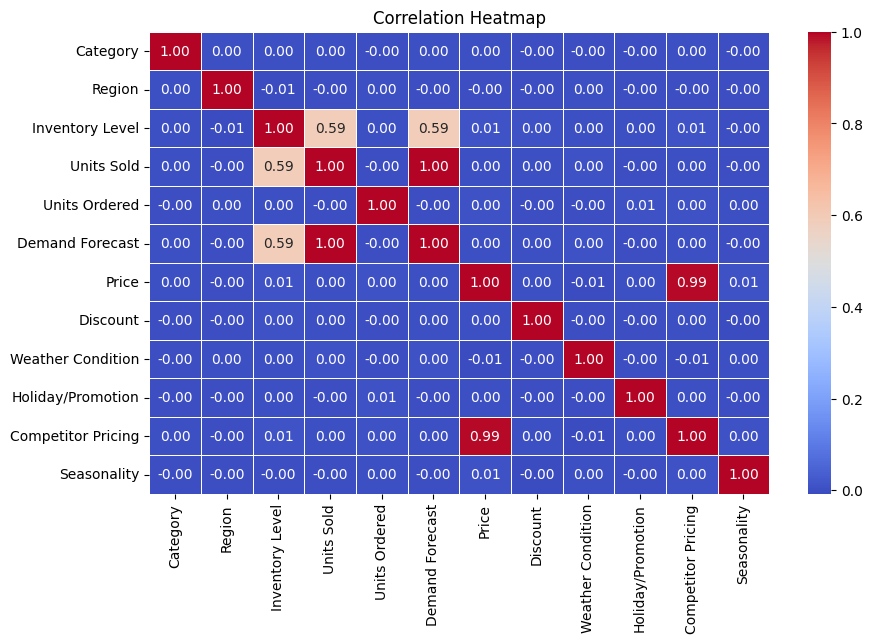

In [ ]:

plt.figure(figsize=(10, 6))
sns.heatmap(corrlation.corr(),annot=True,cmap='coolwarm',linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

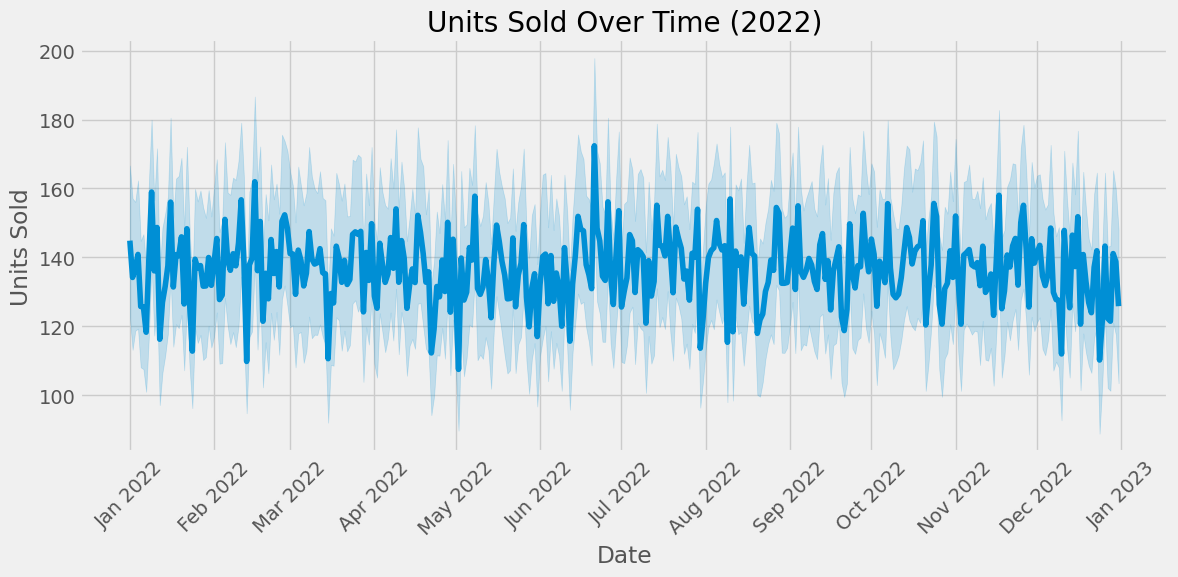

In [83]:
# Convert 'Date' column to datetime format
data_sales['Date'] = pd.to_datetime(data_sales['Date'])

# Now filter the correct date range
filtered_data = data_sales[(data_sales['Date'] >= '2022-01-01') & (data_sales['Date'] <= '2022-12-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='Date', y='Units Sold')

plt.title('Units Sold Over Time (2022)')
plt.xlabel('Date')
plt.ylabel('Units Sold')

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2022"

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


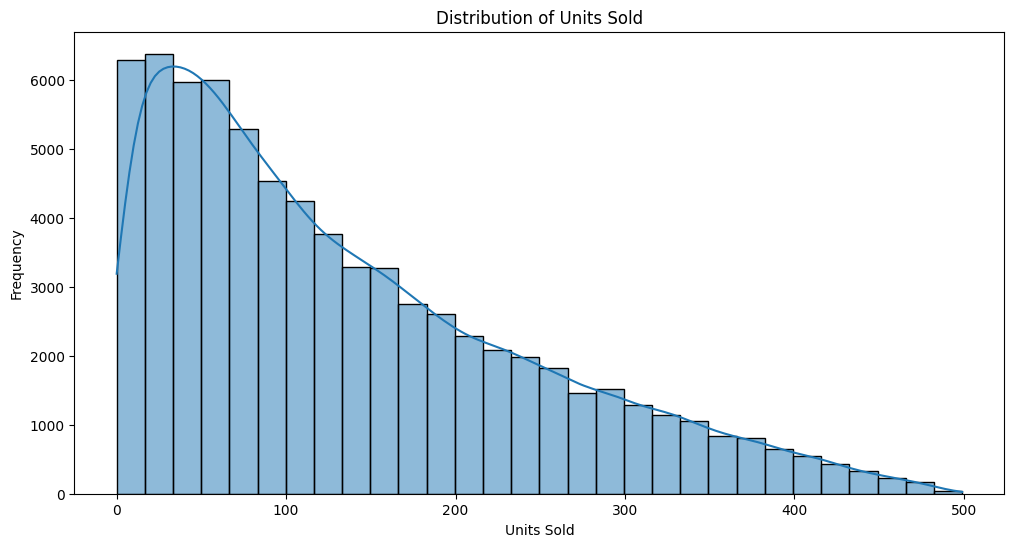

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_sales, x='Units Sold', bins=30, kde=True)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

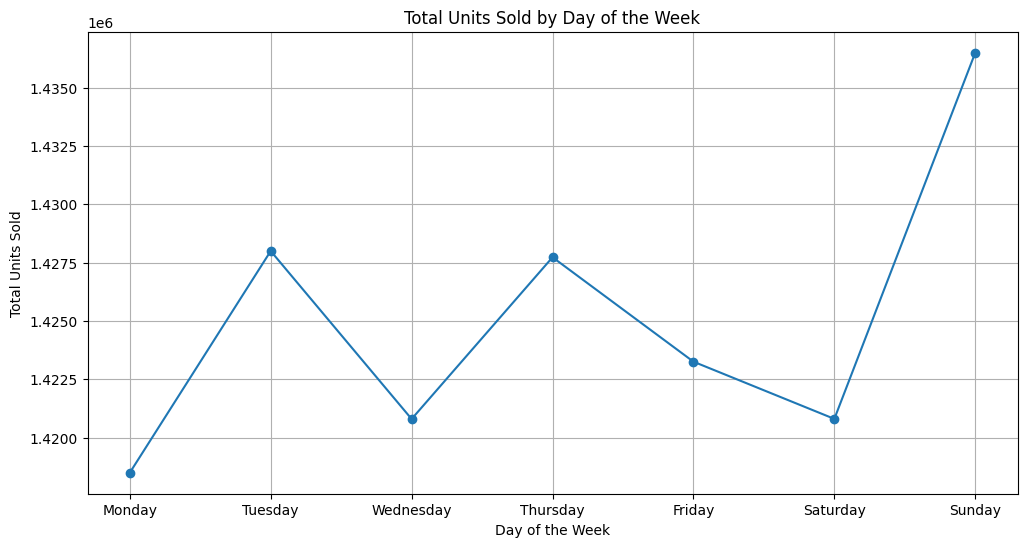

In [ ]:
# Extract day of the week from the Date column
data_sales['DayOfWeek'] = pd.to_datetime(data_sales['Date']).dt.day_name()

# Group by day of the week and sum the units sold
daily_sales = data_sales.groupby('DayOfWeek')['Units Sold'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the data
plt.figure(figsize=(12, 6))
daily_sales.plot(kind='line', marker='o')
plt.title('Total Units Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Units Sold')
plt.grid(True)
plt.show()

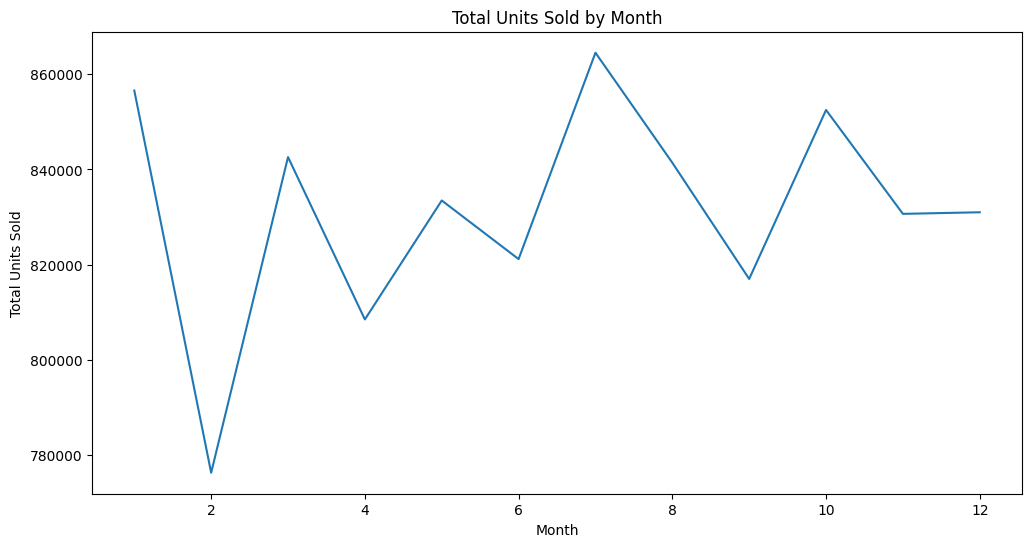

In [ ]:
data_sales['Month'] = pd.to_datetime(data_sales['Date']).dt.month
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_sales, x='Month', y='Units Sold', estimator=sum, ci=None)
plt.title('Total Units Sold by Month')
plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.show()

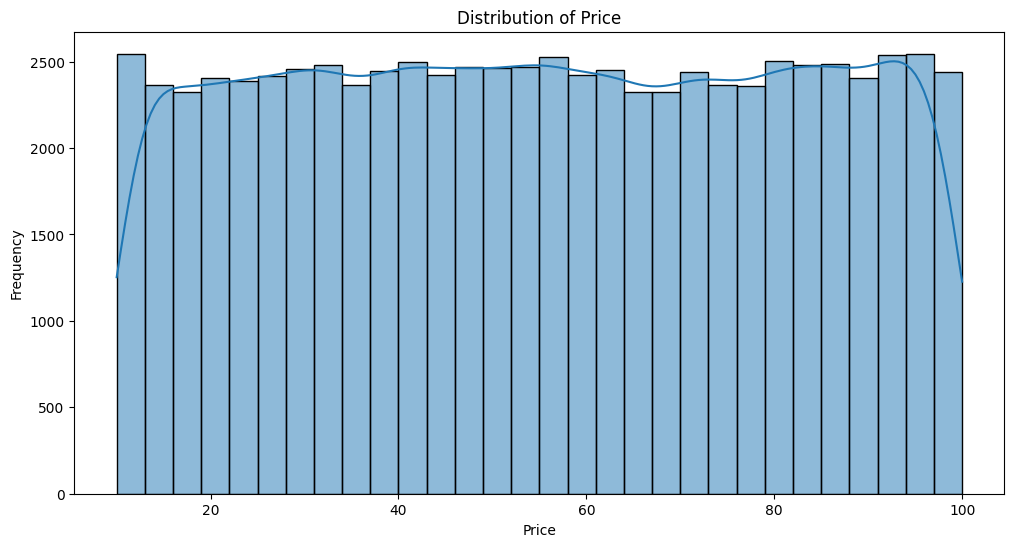

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_sales, x='Price', bins=30, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

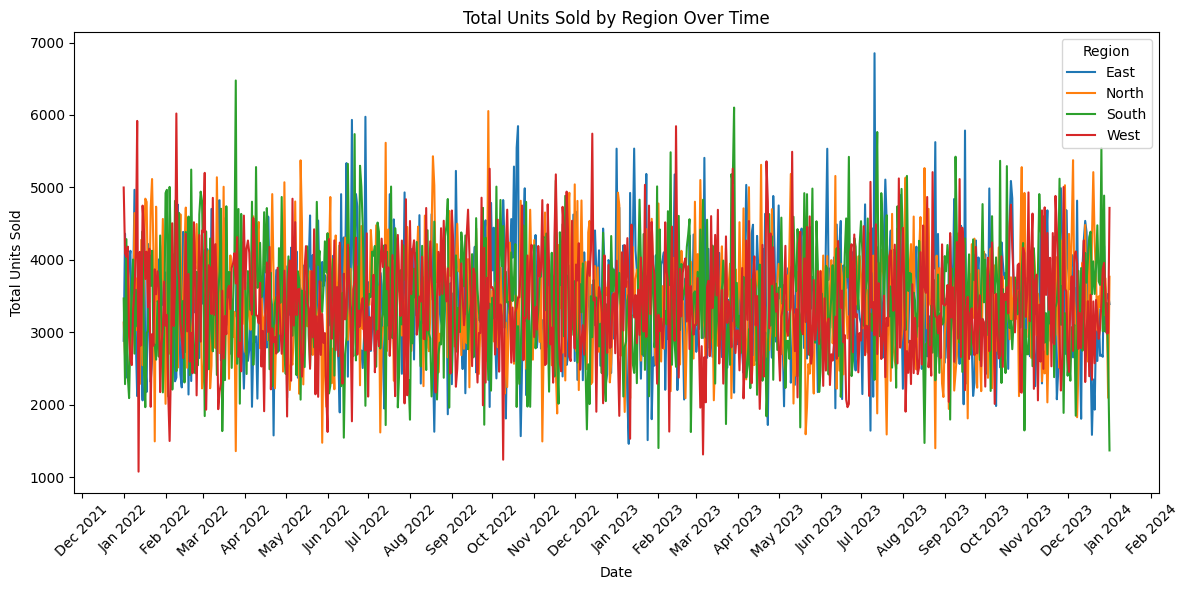

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
sns.lineplot(data=data_sales, x='Date', y='Units Sold', hue='Region', estimator=sum, ci=None)

plt.title('Total Units Sold by Region Over Time')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')

# Fix the X-axis formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2022"

plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()  # Adjust layout to prevent cutoff
plt.show()


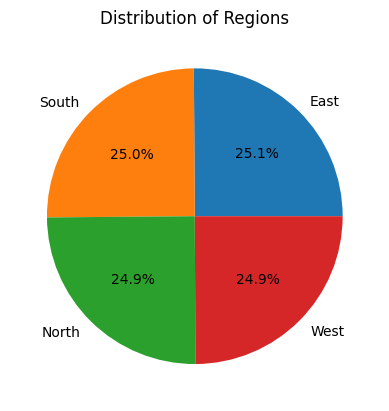

In [ ]:
plt.pie(data_sales['Region'].value_counts(), labels=data_sales['Region'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Regions')
plt.show()

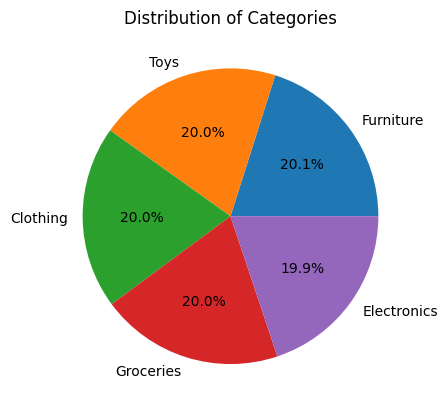

In [ ]:
plt.pie(data_sales['Category'].value_counts(), labels=data_sales['Category'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.show()

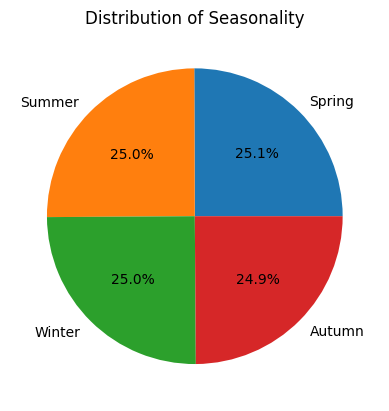

In [ ]:
plt.pie(data_sales['Seasonality'].value_counts(), labels=data_sales['Seasonality'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Seasonality')
plt.show()

In [93]:

fig=px.bar(data_sales,x='Weather Condition',y='Units Sold',color='Weather Condition',color_discrete_map={  # Assign specific colors
        'Rainy': 'blue',
        'Sunny': 'orange',
        'Cloudy': 'grey',
        'Snowy': 'lightblue'
    })
fig.show()

In [89]:
px.area(data_sales,x='Date',y='Units Sold',color='Region')

In [ ]:

px.bar(data_sales,x='Category',y='Units Sold',color='Seasonality',barmode='group')


In [ ]:
pip install prophet

# **Feature Engineering**

In [ ]:
data_sales['Date'].min(),data_sales['Date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00'))

In [24]:
# Step 1: Prepare Prophet Data
# Step 1: Aggregate demand by day
daily_df = data_sales.copy()
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Group by day: total demand per date
daily_df = daily_df.groupby('Date', as_index=False)['Demand Forecast'].sum()

# Add engineered features
daily_df['day_of_week'] = daily_df['Date'].dt.dayofweek
daily_df['month'] = daily_df['Date'].dt.month
daily_df['is_weekend'] = daily_df['day_of_week'].isin([5, 6]).astype(int)


# Rename for Prophet
daily_df = daily_df.rename(columns={'Date': 'ds', 'Demand Forecast': 'y'})


In [37]:
daily_df.shape


(731, 5)

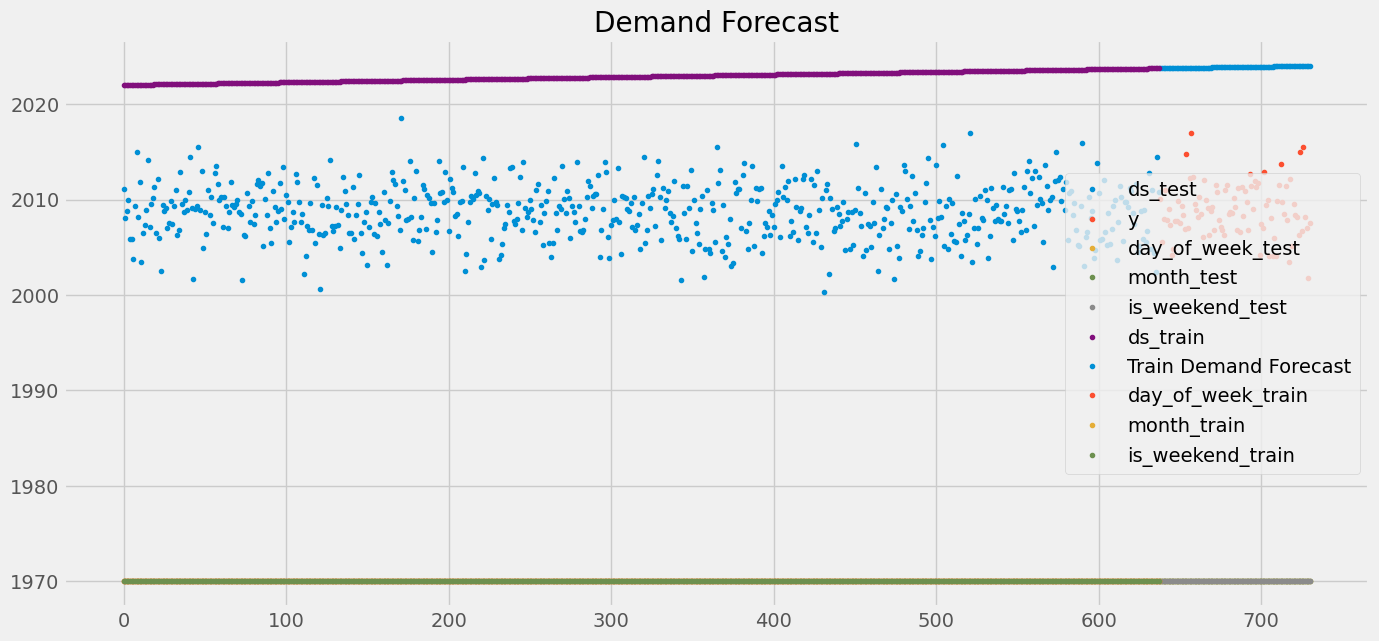

In [21]:
# spliting by date
split_date = '2023-10-01'
train_df = daily_df[daily_df['ds'] < split_date]
test_df = daily_df[daily_df['ds'] >= split_date]

test_df.rename(columns={'y':'Test Demand Forecast'})
test_df.join(train_df.rename(columns={'y':'Train Demand Forecast'}),
how='outer',lsuffix='_test',
    rsuffix='_train').plot(figsize=(15, 7),title = 'Demand Forecast', style='.')
plt.show()

In [ ]:
test_df.shape,train_df.shape

((93, 5), (638, 5))

In [54]:

# Step 3: Prophet Model with Regressors
m = Prophet()
m.add_regressor('day_of_week')
m.add_regressor('month')
m.add_regressor('is_weekend')

# Train the model
m.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

# Step 4: Create future dataframe and forecast
future = m.make_future_dataframe(periods=len(test_df), freq='D')
future['day_of_week'] = future['ds'].dt.dayofweek
future['month'] = future['ds'].dt.month
future['is_weekend'] = future['day_of_week'].isin([5, 6]).astype(int)

forecast = m.predict(future)

# Step 5: Evaluation
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyf7862tf/psyyzhwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyf7862tf/d1j09h6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25841', 'data', 'file=/tmp/tmpyf7862tf/psyyzhwv.json', 'init=/tmp/tmpyf7862tf/d1j09h6w.json', 'output', 'file=/tmp/tmpyf7862tf/prophet_model4cfv0f5g/prophet_model-20250419164333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:43:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:43:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 1024.59
MAE: 798.55
MAPE: 5.60%


Trend and Seasonality Analysis

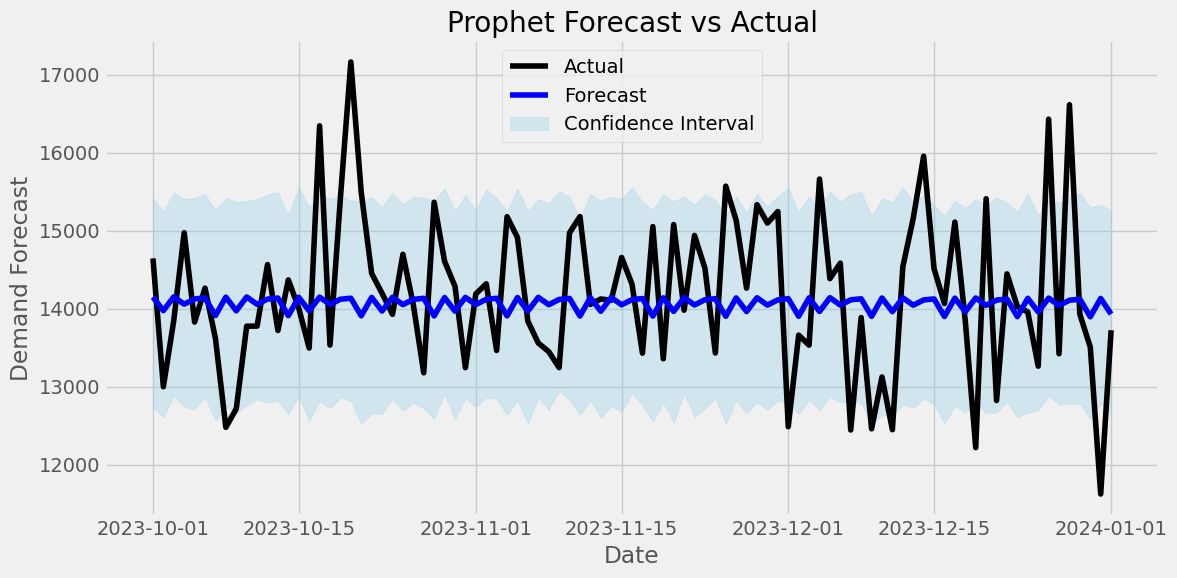

In [55]:
# Step 6: Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_true, label='Actual', color='black')
plt.plot(test_df['ds'], y_pred, label='Forecast', color='blue')
plt.fill_between(test_df['ds'],
                 forecast_test['yhat_lower'],
                 forecast_test['yhat_upper'],
                 color='skyblue', alpha=0.3, label='Confidence Interval')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2023-10-01  14063.669144  12754.406474  15373.756174  14063.669144   
1 2023-10-02  14063.423061  12694.085894  15491.709111  14063.423061   
2 2023-10-03  14063.176979  12809.771992  15500.793813  14063.176979   
3 2023-10-04  14062.930897  12715.724878  15351.387291  14062.930897   
4 2023-10-05  14062.684814  12760.421628  15501.660909  14062.684814   

    trend_upper  New Year's Day  New Year's Day_lower  New Year's Day_upper  \
0  14063.669144             0.0                   0.0                   0.0   
1  14063.423061             0.0                   0.0                   0.0   
2  14063.176979             0.0                   0.0                   0.0   
3  14062.930897             0.0                   0.0                   0.0   
4  14062.684814             0.0                   0.0                   0.0   

   additive_terms  ...  holidays  holidays_lower  holidays_upper     weekly  \
0       76.091156  ...       0.0             0.0             0.0  76.091156   
1      -98.473164  ...       0.0             0.0             0.0 -98.473164   
2       79.044605  ...       0.0             0.0             0.0  79.044605   
3      -15.367600  ...       0.0             0.0             0.0 -15.367600   
4       52.404743  ...       0.0             0.0             0.0  52.404743   

   weekly_lower  weekly_upper  multiplicative_terms  \
0     76.091156     76.091156                   0.0   
1    -98.473164    -98.473164                   0.0   
2     79.044605     79.044605                   0.0   
3    -15.367600    -15.367600                   0.0   
4     52.404743     52.404743                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  14139.760300  
1                         0.0                         0.0  13964.949897  
2                         0.0                         0.0  14142.221584  
3                         0.0                         0.0  14047.563296  
4                         0.0                         0.0  14115.089558  

[5 rows x 22 columns]

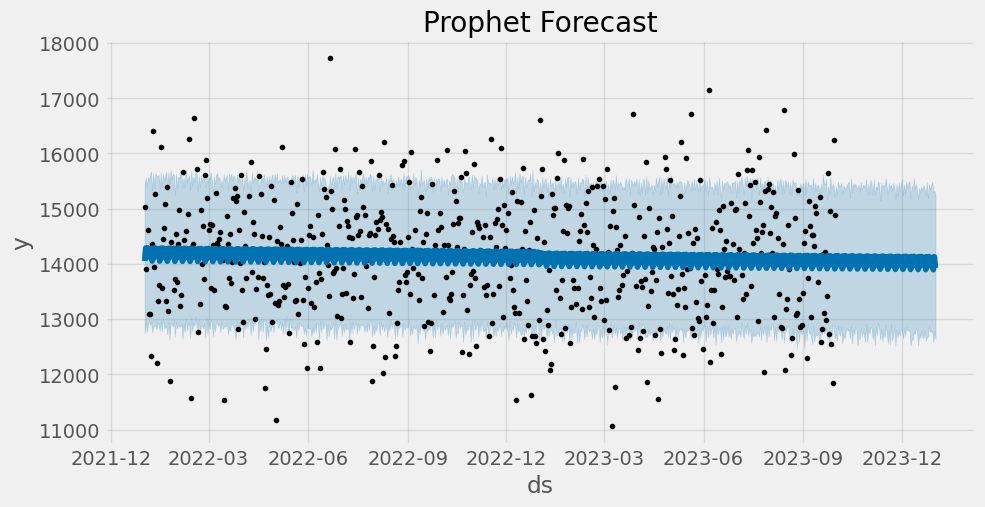

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = m.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

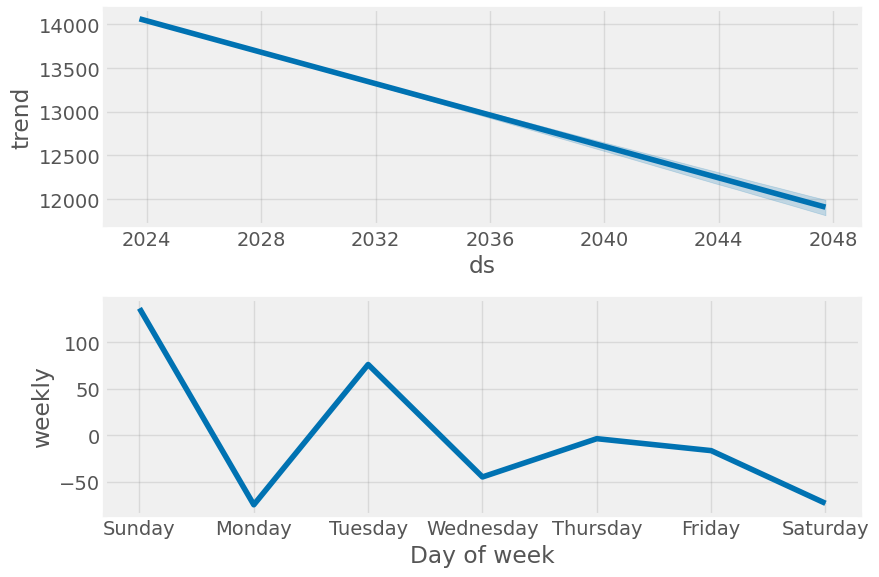

In [85]:
fig = m.plot_components(forecast)
plt.show()

In [79]:


cal = calendar()


holidays = cal.holidays(start=daily_df.index.min(),
                        end=daily_df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [80]:
holiday_df.head()

ds         holiday
0 1970-01-01  New Year's Day

In [66]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyf7862tf/k21zchwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyf7862tf/nvysn8j_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64924', 'data', 'file=/tmp/tmpyf7862tf/k21zchwa.json', 'init=/tmp/tmpyf7862tf/nvysn8j_.json', 'output', 'file=/tmp/tmpyf7862tf/prophet_modelkazd90_1/prophet_model-20250419164512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:45:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:45:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 50.9 ms, sys: 10.7 ms, total: 61.6 ms
Wall time: 80.3 ms


In [67]:
test_fcst_with_hols = model_with_holidays.predict(df=test_df)

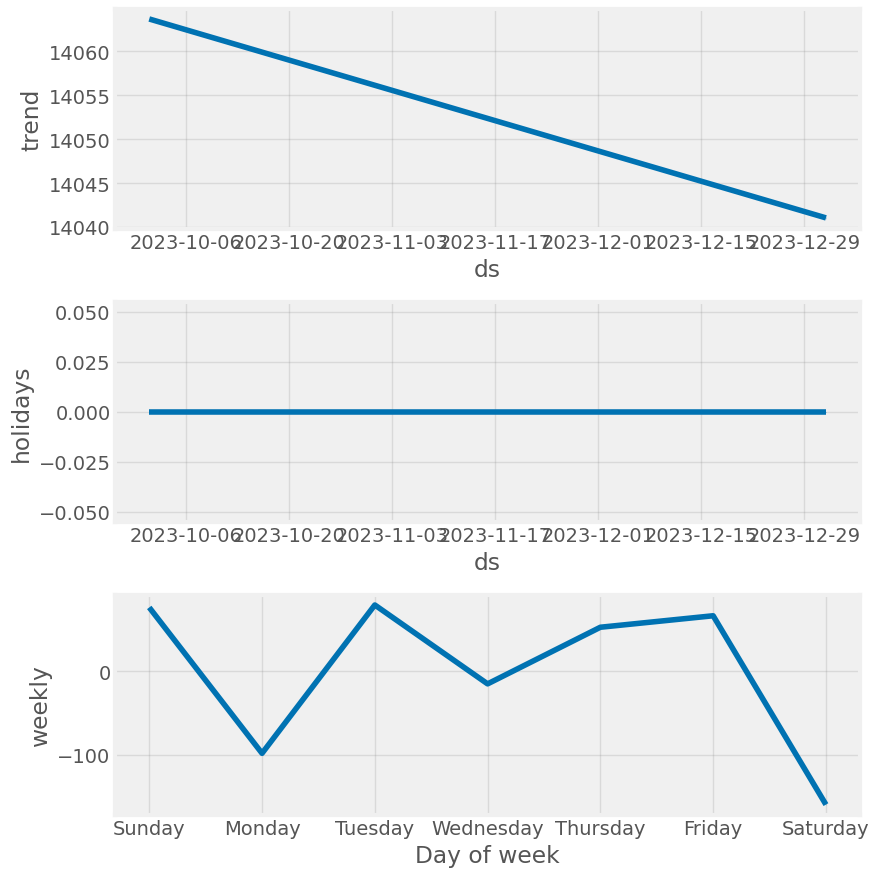

In [68]:
fig = model_with_holidays.plot_components(
    test_fcst_with_hols)
plt.show()

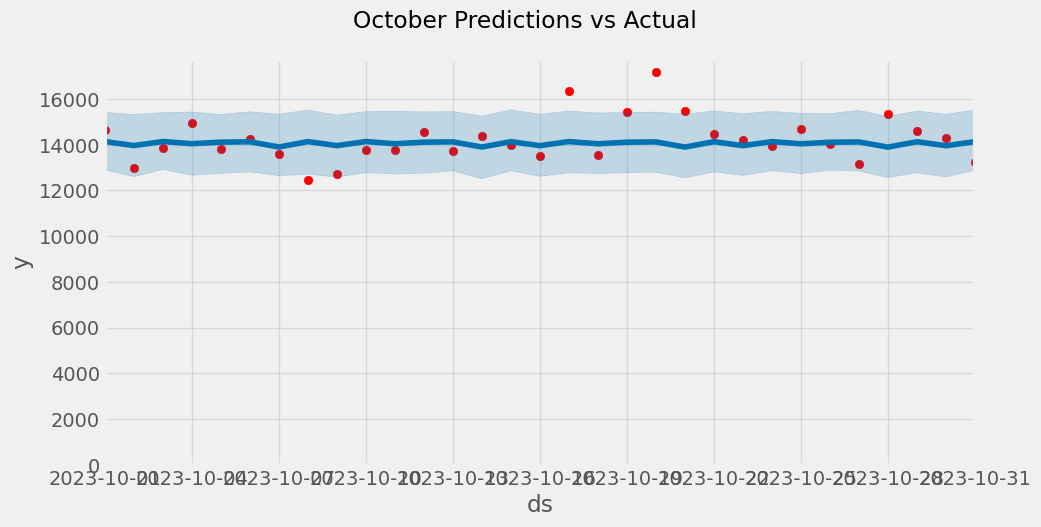

In [72]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_df['ds'], test_df['y'], color='r')

fig = m.plot(test_fcst_with_hols, ax=ax)

# Convert the string dates to datetime objects
lower_bound = pd.to_datetime('2023-10-01')
upper_bound = pd.to_datetime('2023-10-31') # or any other appropriate upper bound for October

ax.set_xlim(lower_bound, upper_bound)
ax.set_ylim(0, daily_df['y'].max())
plot = plt.suptitle('October Predictions vs Actual')


In [70]:
print(np.sqrt(mean_squared_error(y_true=test_df['y'],
                   y_pred=test_fcst_with_hols['yhat'])))

1025.9290103993096


In [46]:
print(mean_absolute_error(y_true=test_df['y'],
                   y_pred=test_fcst_with_hols['yhat']))

799.1133729627112

In [49]:
print(mean_absolute_percentage_error(y_true=test_df['y'],
                   y_pred=test_fcst_with_hols['yhat']))

5.599364329101087


In [73]:
future = m.make_future_dataframe(periods=365*24, freq='D', include_history=False)
forecast = model_with_holidays.predict(future)

In [74]:
forecast[['ds','yhat']].head()

ds          yhat
0 2023-10-01  14139.760300
1 2023-10-02  13964.949897
2 2023-10-03  14142.221584
3 2023-10-04  14047.563296
4 2023-10-05  14115.089558